# ライブラリのインポート

In [ ]:
import pandas as pd

df = pd.read_csv(
    "data/household_power_consumption.txt",
    encoding='utf-8',
    sep=';',
    header=0,                        # 1行目をヘッダーとして読む
    dayfirst=False,                  # mm/dd/yyyy の場合は False
    low_memory=False,
    dtype= {
        "Global_active_power":   "float64",
        "Global_reactive_power": "float64",
        "Voltage":               "float64",
        "Global_intensity":      "float64",
        "Sub_metering_1":        "float64",
        "Sub_metering_2":        "float64",
        "Sub_metering_3":        "float64",
    },
    na_values=["?", ""],  # 欠損値として扱いたい文字列
)

# 日付と時刻の結合
df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)
df = df.set_index("Datetime")
df.drop(columns=["Date", "Time"], inplace=True)

# Sub_metering_* は Wh 単位なので kWh に変換
df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']] = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']] / 1000.0

# 欠損値補間: 時系列線形補間
df.interpolate(method='time', inplace=True)

# 日次データに変更
df_daily = df.resample('D').sum()
print(df_daily.head())

            Global_active_power  Global_reactive_power    Voltage  \
Datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
Datetime                                                                      
2006-12-16            5180.8           0.000           0.546           4.926  
2006-12-17           14398.6           2.033           4.187          13.341  
2006-12-18            9247.2           1.063           2.621          14.018  
2006-12-19            7094.0           0.839           7.602           6.197  
2006-12-20            9313.0           0.0

# 自己相関性

対象データが多重周期性を持つことを示す


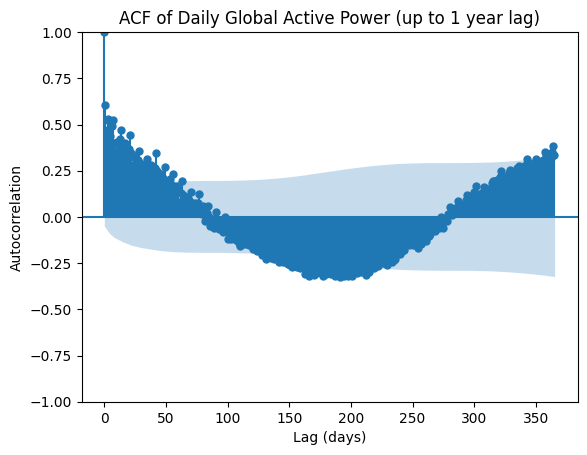

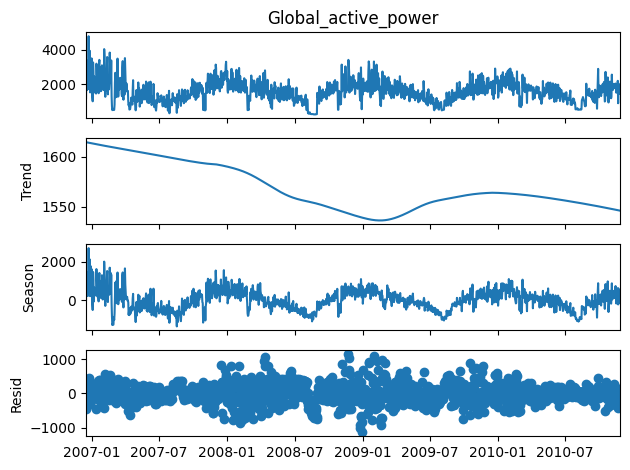

In [38]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# 例：1日周期（日次集約データで週次・年次を見る場合）
# df_daily: 日次平均データ（インデックスが DatetimeIndex）
df_daily = df.resample('D').sum()
series = df_daily['Global_active_power']  # 1次元データを取り出し

plot_acf(series, lags=365)  # 2年分までのラグを表示
plt.title("ACF of Daily Global Active Power (up to 1 year lag)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.show()


from statsmodels.tsa.seasonal import STL
stl = STL(df_daily['Global_active_power'], period=365)
res = stl.fit()
res.plot()
plt.tight_layout()
plt.show()

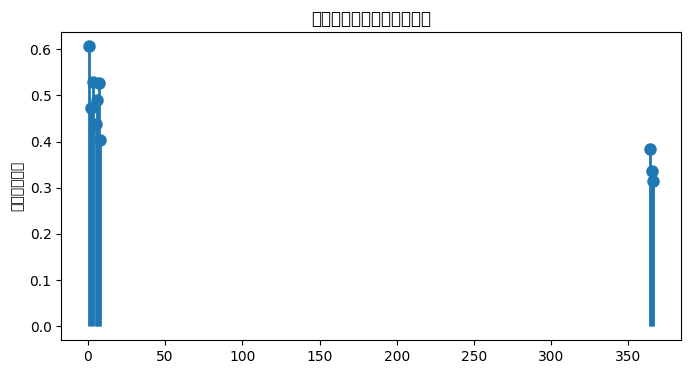

In [42]:
import pandas as pd
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

# 日次データ df_daily['Global_active_power'] を前提
series = df_daily['Global_active_power']

# 自己相関係数を最大 366 日分まで計算
acf_vals = acf(series, nlags=366, fft=False)

# 強調したいラグ
highlight_lags = [1, 2, 3, 5, 6, 7, 8,  364, 365, 366]

# プロット
plt.figure(figsize=(8, 4))
markerline, stemlines, baseline = plt.stem(
    highlight_lags,
    acf_vals[highlight_lags],
    basefmt=" "  # 基準線のフォーマット（空文字で非表示）
)
plt.setp(markerline, marker='o', markersize=8)  # マーカー調整
plt.setp(stemlines, linestyle='-', linewidth=2)  # 線の調整

# plt.xticks(highlight_lags, ['1 day', '7 days', '365 days'])
plt.ylabel('自己相関係数')
plt.title('主要周期における自己相関')
plt.show()